In [1]:
import spotchaos.syntheticSignals as sp

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.animation import TimedAnimation
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import pickle

import os
from astropy.timeseries import LombScargle
from scipy.integrate import RK45, DOP853
from scipy.stats import chi2, iqr
from scipy.signal import argrelextrema, savgol_filter, find_peaks_cwt
from scipy.spatial.distance import chebyshev
from scipy.optimize import curve_fit

from pytisean import tiseano, tiseanio

from sklearn.neighbors import KDTree, BallTree
from scipy.spatial import KDTree as scipyKDTree

#%matplotlib inline

In [2]:
# Time series:
# 0. White noise
# 1. stationary GP time series
# 2. Simple periodic
# 3. KB88 R(t)
# 4. Rossler x, y, z
# 5. Transformed rossler u, v, w
# 6. Lorenz x, y, z

# and for each we have 3 baselines: TESS (perfect = 257062 data points), Kepler (perfect = 71422 data points), SPECULOOS (perfect = 44119 data points)
#                   and 4 versions: perfect, gapless+noisy, gappy+noiseless, realistic
# yielding 13*3*4 = 156 time series to analyze altogether. (But only 78 files, because the perfect and noisy versions are in the same file.)

# Need to choose:
# 1. time delay (Fraser & Swinney 1986)
# 2. embedding dimension (Cao 1997)
# and then calculate
# 1. correlation dimension (Kurths & Herzel 1987; investigate pytisean too. Look into Thelier window.)
# 2. Lyapunov spectrum (Wolf et al. 1985)
# 3. Lyapunov dimension (Kaplan-Yorke conjecture; see Eckmann & Ruelle 1985 eq 4.11).

# Expected results:
# 0. White noise should have no good choice of time delay; mutual info as a function of delay time should be flat.
# 1. Not sure!
# 2. Simple periodic and KB88 R(t) results should be similar to KB88 figures 9 and 10.
# 3. same
# 4. Rossler x, y, and z should yield time delay ~ 1/4*rossler_qp and embedding dimension of 3. Rossler z results should be worse than x and y.
# 5. Transformed Rossler u, v, and w should yield time delay ~1/4*transformed_rossler_qp and embedding dimension of 3. Variables should be about equally good.
# 6. Lorenz x, y, and z should yield time delay ~1/4*lorenz_qp and embedding dimension of 3. z dimension will be insensitive to wing symmetry.


In [3]:
folderpaths = ['0_gaussian_noise',
               '1_gaussian_process',
               '2_simple_periodic',
               '3_KB88_r',
               '4_rossler',
               '5_transformed_rossler',
               '6_lorenz']

In [4]:
class timeSeriesParams(object):
    def __init__(self, filename, filepath, **kwargs):
        self.filename = filename
        self.filepath = filepath
        self.QPmethod = None
        self.QP = None
        self.noisy_QP = None
        self.bestTauIdx = None
        self.noisy_bestTauIdx = None
        self.sat_m = None
        self.noisy_sat_m = None

        self.euclideanCq = None
        self.noisy_euclideanCq = None
        self.euclideanD2 = None
        self.noisy_euclideanD2 = None

        self.tiseanC2 = None
        self.noisy_tiseanC2 = None
        self.tiseanD2 = None
        self.noisy_tiseanD2 = None
        self.tiseanH2 = None
        self.noisy_tiseanH2 = None

        allowed_keys = ["QPmethod","QP","noisy_QP","bestTauIdx","noisy_bestTauIdx","sat_m","noisy_sat_m","euclideanCq","noisy_euclideanCq","euclideanD2","noisy_euclideanD2","tiseanC2","noisy_tiseanC2","tiseanD2","noisy_tiseanD2","tiseanH2","noisy_tiseanH2"]
		
        self.__dict__.update((k,v) for k,v in kwargs.items() if k in allowed_keys)
		
        

In [5]:
def has_stepsize_one(it):
    return all(x2 - x1 == 1 for x1, x2 in zip(it[:-1], it[1:]))

0_gaussianNoise_speculoos_perfect.txt
[ 6  7  8  9 10]
[ 6  7  8  9 10]


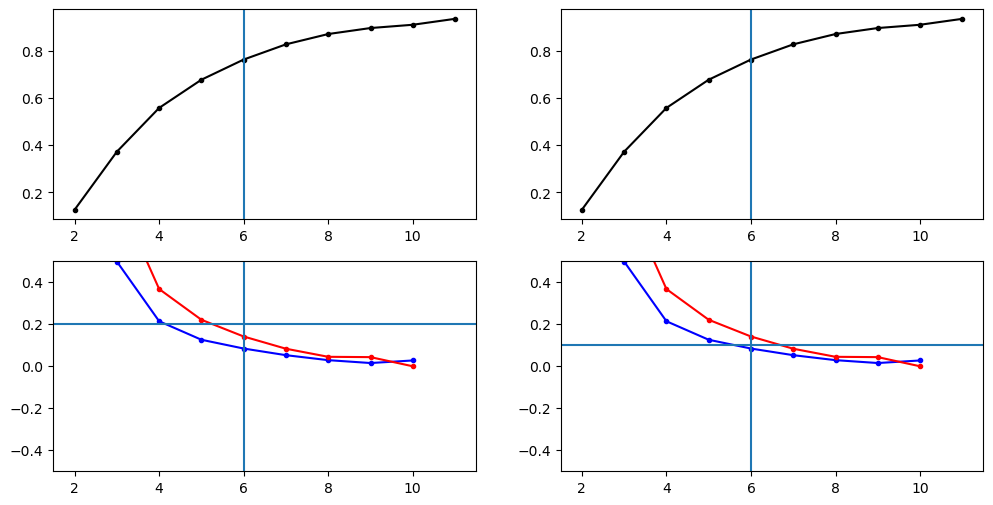

1_gaussianProcess_speculoos_perfect.txt
[ 5  6  7  8  9 10]
[ 5  6  7  8  9 10]


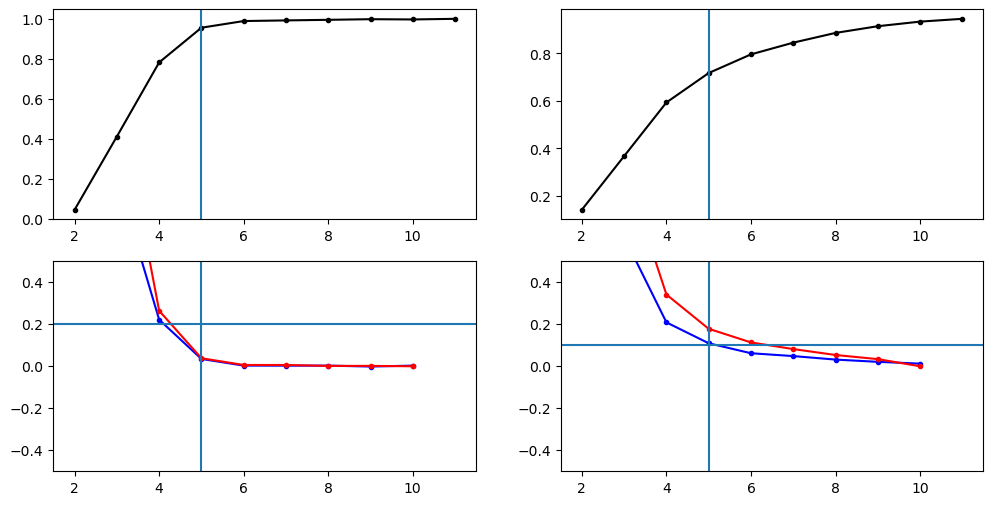

2_simplePeriodic_speculoos_perfect.txt
[ 4  5  6  7  8  9 10]
[ 5  6  7  8  9 10]


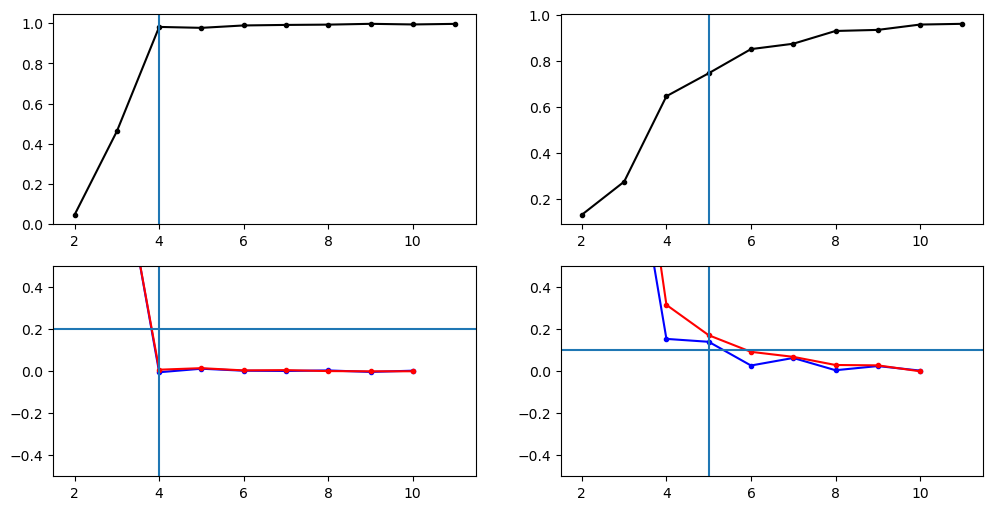

3_KB88r_speculoos_perfect.txt
[ 5  6  7  8  9 10]
[ 5  6  7  8  9 10]


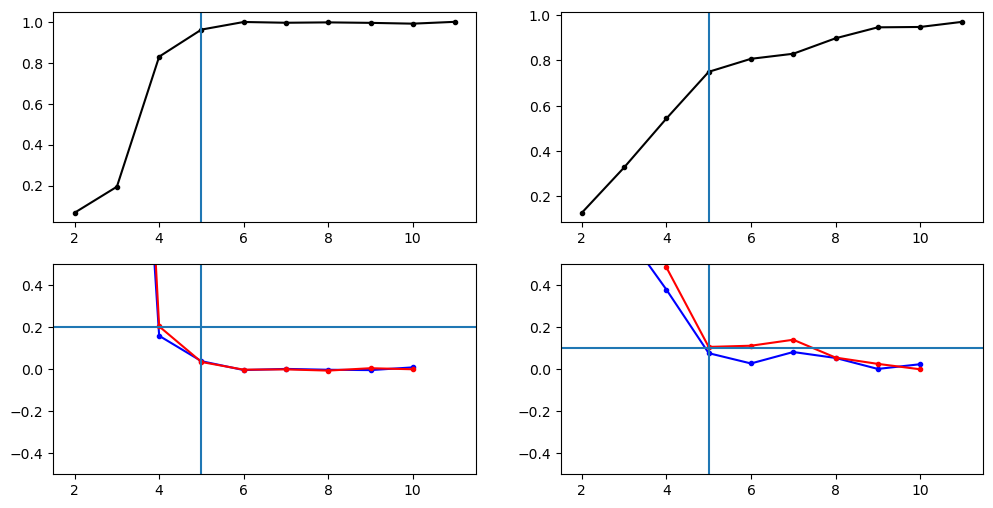

4_rossler_x_speculoos_perfect.txt
[ 3  4  5  6  7  8  9 10]
[ 5  6  7  8  9 10]


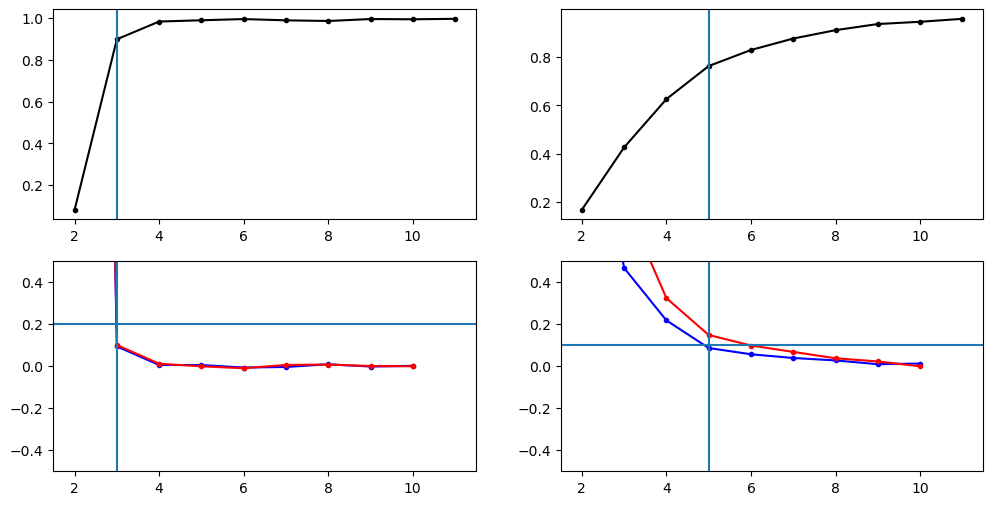

4_rossler_z_speculoos_perfect.txt
[3 6 9]
[ 6  7  8  9 10]
sat_m is None
[3 6 9]


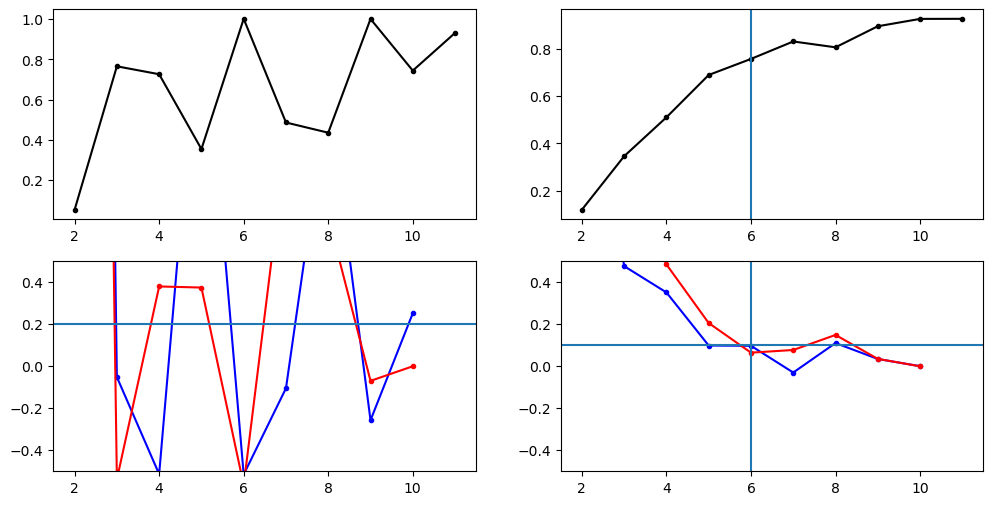

4_rossler_y_speculoos_perfect.txt
[ 3  4  5  6  7  8  9 10]
[ 5  6  7  8  9 10]


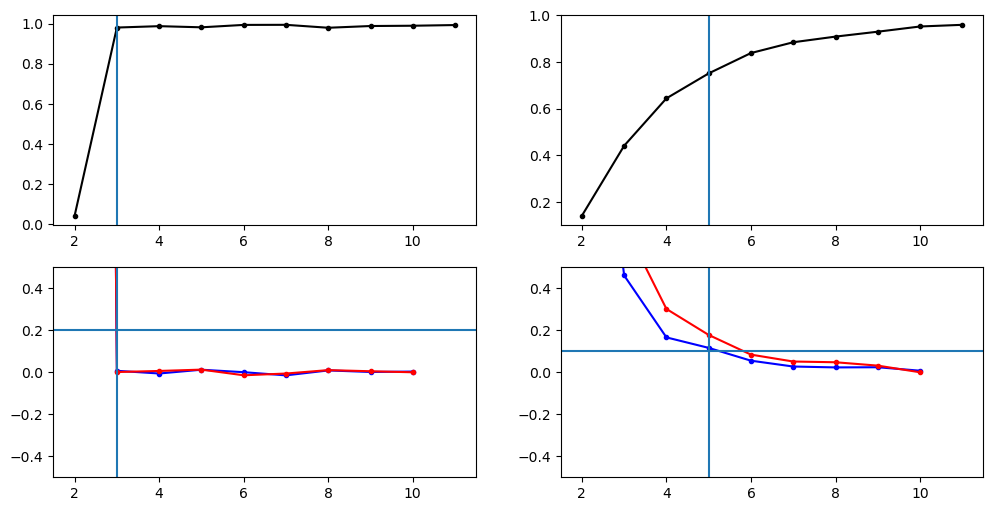

5_transformed_rossler_z_speculoos_perfect.txt
[ 3  4  5  6  7  8  9 10]
[ 5  6  7  8  9 10]


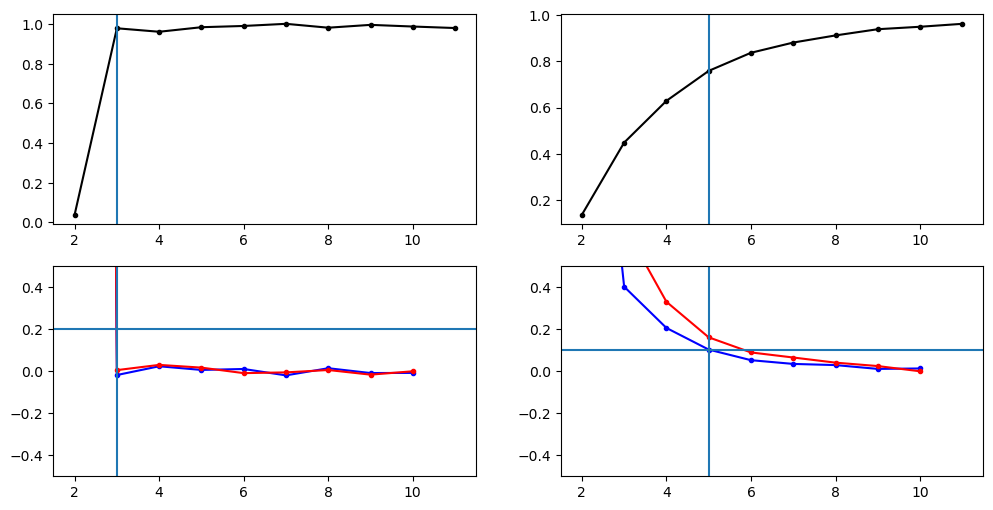

5_transformed_rossler_x_speculoos_perfect.txt
[ 3  4  5  6  7  8  9 10]
[ 5  6  7  8  9 10]


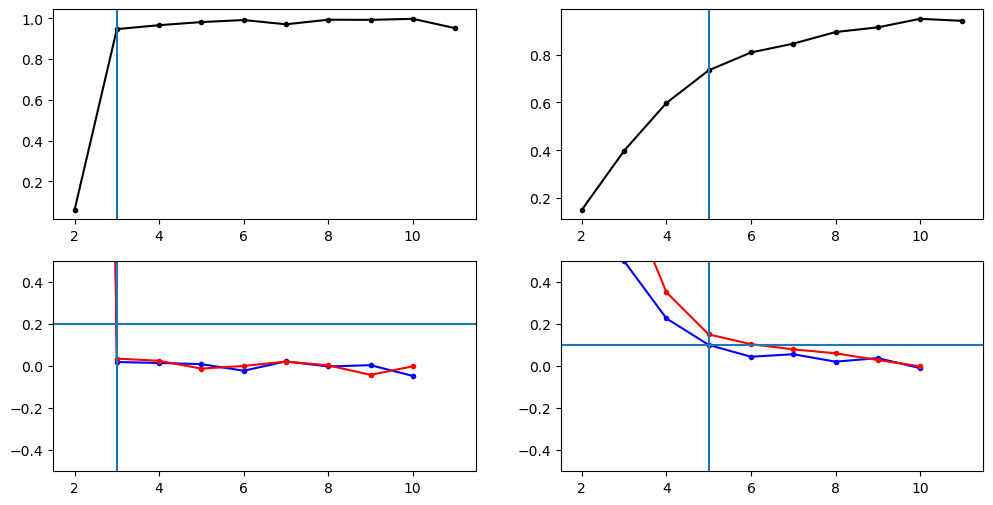

5_transformed_rossler_y_speculoos_perfect.txt
[ 3  4  5  6  7  8  9 10]
[ 5  6  7  8  9 10]


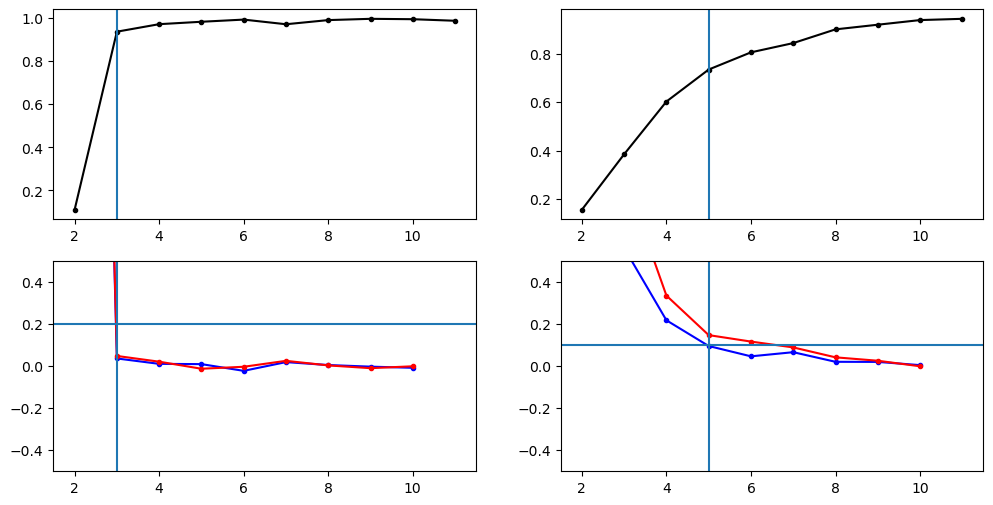

6_lorenz_x_speculoos_perfect.txt
[ 4  5  6  7  8  9 10]
[ 5  6  7  8  9 10]


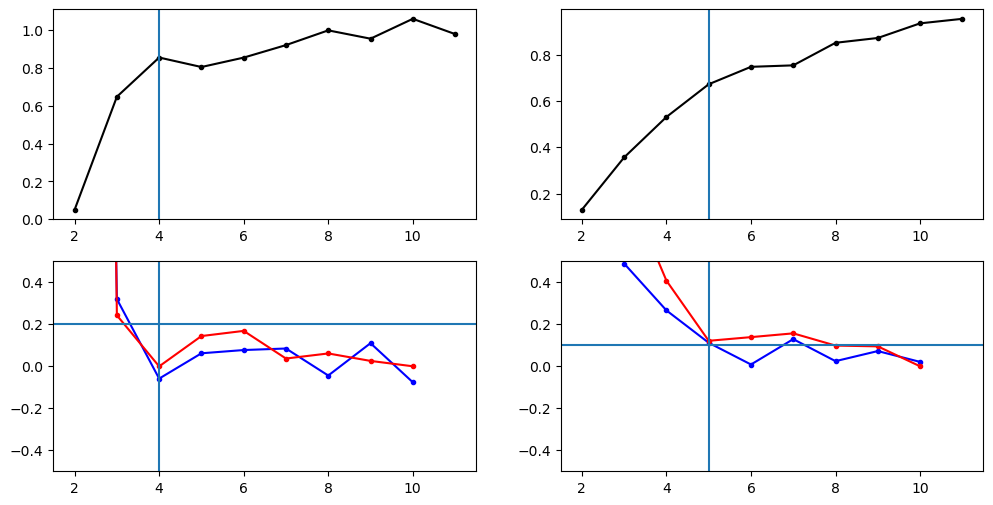

6_lorenz_z_speculoos_perfect.txt
[ 4  5  6  7  8  9 10]
[ 5  6  7  8  9 10]


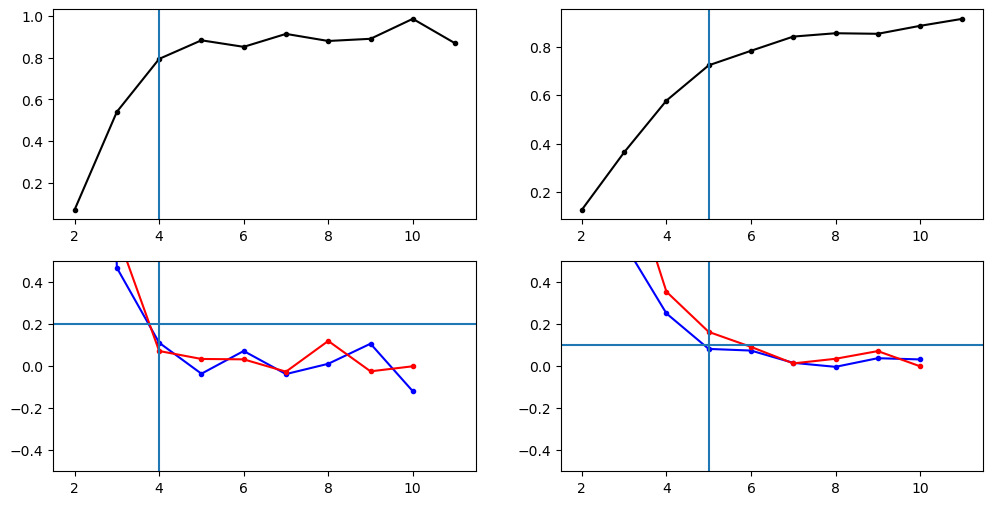

6_lorenz_y_speculoos_perfect.txt
[ 4  5  6  7  8  9 10]
[ 5  6  7  8  9 10]


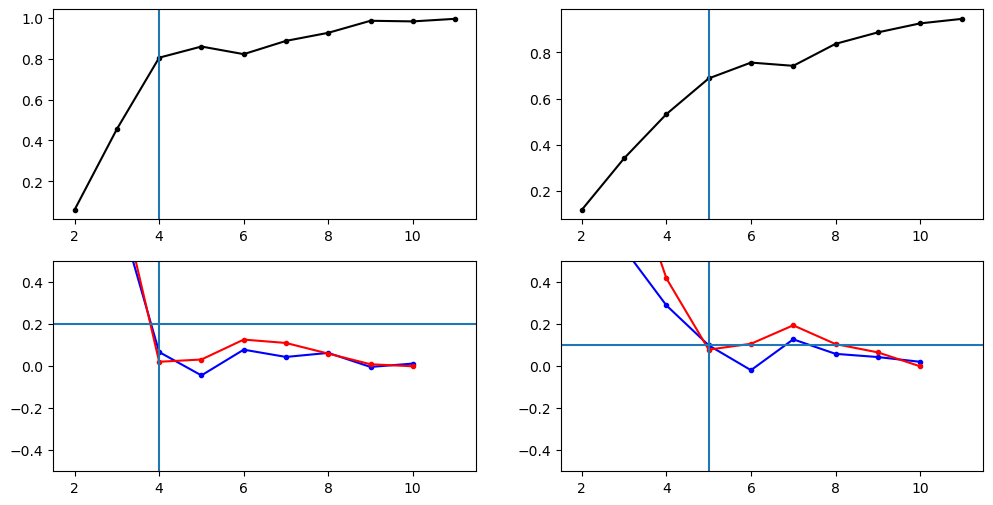

In [27]:
# Make a dictionary so we don't have to keep rerunning the FS86 and cao97 steps.
for folder in folderpaths:
    files = os.scandir("../data/{0}/".format(folder))
    for file in files:
        if ".txt" in file.name and "perfect" in file.name and "speculoos" in file.name:
            print(file.name)
            data = np.genfromtxt(file.path)
            
            if "0" in file.name:
                ts = data[:,2]
                noisy_ts = data[:,2]
            else:
                ts = data[:,1]
                noisy_ts = data[:,2]
                
            if "lorenz" in file.name and "_z_" not in file.name:
                QPmethod = "localMaxSep"
            elif "0" in file.name:
                QPmethod = "localMaxSep"
            else:
                QPmethod = "power"

            # choose time delay (Fraser & Swinney 1986)
            if "0" in file.name:
                mutInfo, bestTauIdx, qp = sp.FS86(time = data[:,0], timeSeries = ts, QPmethod=QPmethod, method="global_min", plot=False)
                noisy_mutInfo, noisy_bestTauIdx, noisy_qp = sp.FS86(time = data[:,0], timeSeries = noisy_ts, QPmethod=QPmethod, method="global_min", plot=False)
            else:
                mutInfo, bestTauIdx, qp = sp.FS86(time = data[:,0], timeSeries = ts, QPmethod=QPmethod, method="first_or_second_local_min", plot=False)
                noisy_mutInfo, noisy_bestTauIdx, noisy_qp = sp.FS86(time = data[:,0], timeSeries = noisy_ts, QPmethod=QPmethod, method="first_or_second_local_min", plot=False)


            E1_change_cutoff=0.2
            mMax = 10
            
            # choose embedding dimension (Cao 1997)
            E1, E2 = sp.cao97(timeSeries=ts, tau=bestTauIdx, mMax=mMax+2)
            percentChange_E1_i_ip1 = (E1[1:] - E1[0:-1])/E1[0:-1]
            percentChange_E1_i_ip2 = np.zeros_like(percentChange_E1_i_ip1)
            percentChange_E1_i_ip2[:-1] = (E1[2:] - E1[0:-2])/E1[0:-2]

            stableMask = (percentChange_E1_i_ip1 < E1_change_cutoff) & (percentChange_E1_i_ip2 < E1_change_cutoff)
            stableInds = np.arange(2,mMax+1)[stableMask]
            print(stableInds)
            
            noisy_E1, noisy_E2 = sp.cao97(timeSeries=noisy_ts, tau=noisy_bestTauIdx, mMax=mMax+2)
            noisy_percentChange_E1_i_ip1 = (noisy_E1[1:] - noisy_E1[0:-1])/noisy_E1[0:-1]
            noisy_percentChange_E1_i_ip2 = np.zeros_like(noisy_percentChange_E1_i_ip1)
            noisy_percentChange_E1_i_ip2[:-1] = (noisy_E1[2:] - noisy_E1[0:-2])/noisy_E1[0:-2]
            
            noisy_stableMask = (noisy_percentChange_E1_i_ip1 < E1_change_cutoff) & (noisy_percentChange_E1_i_ip2 < E1_change_cutoff)
            noisy_stableInds = np.arange(2,mMax+1)[noisy_stableMask]
            print(noisy_stableInds)
            
            #sat_m = stableInds[0]
            #noisy_sat_m = noisy_stableInds[0]
            
            if has_stepsize_one(stableInds): 
                sat_m = stableInds[0]
            else:
                sat_m = None
                print("sat_m is None")
                print(stableInds)

            if has_stepsize_one(noisy_stableInds):
                noisy_sat_m = noisy_stableInds[0]
            else:
                noisy_sat_m = None
                print("noisy_sat_m is None")
                print(noisy_stableInds)
            
            
            fig, axes = plt.subplots(2,2,figsize=(12,6))
            axes[0,0].plot(np.arange(2,mMax+2),E1,'k.',ls='-')
            axes[1,0].plot(np.arange(2,mMax+1),percentChange_E1_i_ip1,'b.',ls='-')
            axes[1,0].plot(np.arange(2,mMax+1),percentChange_E1_i_ip2,'r.',ls='-')
            axes[1,0].axhline(E1_change_cutoff)
            for ax in axes[:,0]:
                if sat_m is not None:
                    ax.axvline(sat_m)
            
            axes[0,1].plot(np.arange(2,mMax+2),noisy_E1,'k.',ls='-')
            axes[1,1].plot(np.arange(2,mMax+1),noisy_percentChange_E1_i_ip1,'b.',ls='-')
            axes[1,1].plot(np.arange(2,mMax+1),noisy_percentChange_E1_i_ip2,'r.',ls='-')
            axes[1,1].axhline(0.1)
            for ax in axes[:,1]:
                if noisy_sat_m is not None:
                    ax.axvline(noisy_sat_m)
        
            for ax in np.ravel(axes):
                ax.set_xlim(1.5,mMax+1.5)

            for ax in axes[1]:
                ax.set_ylim(-0.5,0.5)
            
            plt.show()
            
            tsp = timeSeriesParams(filename=file.name, filepath=file.path, QPmethod=QPmethod, QP=qp, noisy_QP=noisy_qp, bestTauIdx=bestTauIdx, noisy_bestTauIdx=noisy_bestTauIdx, sat_m=sat_m, noisy_sat_m=noisy_sat_m)
            with open('{0}.pickle'.format(tsp.filename.split(".txt")[0]), 'wb') as f:
                # Pickle the 'data' dictionary using the highest protocol available.
                pickle.dump(tsp, f)
            